In [7]:
from dotenv import load_dotenv
load_dotenv()

True

In [8]:
import operator
import requests
from typing import TypedDict, Annotated
from ddgs import DDGS

In [12]:
from langgraph.graph import StateGraph, END
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_groq import ChatGroq
from langchain_core.tools import tool

In [13]:
@tool
def get_weather(location: str):
    """
    Fetches the current weather for a location using the Open-Meteo API.
    It first converts the location name to coordinates, then gets the weather.
    """
    try:
        # Step 1: Geocoding (convert city name to lat/lon)
        geo_url = f"https://geocoding-api.open-meteo.com/v1/search?name={location}&count=1"
        geo_response = requests.get(geo_url)
        geo_response.raise_for_status()
        geo_data = geo_response.json()

        if not geo_data.get("results"):
            return f"Could not find coordinates for '{location}'."

        res = geo_data["results"][0]
        lat, lon = res["latitude"], res["longitude"]
        city_name = res["name"]

        # Step 2: Get weather using coordinates
        weather_url = f"https://api.open-meteo.com/v1/forecast?latitude={lat}&longitude={lon}&current=temperature_2m,weather_code"
        weather_response = requests.get(weather_url)
        weather_response.raise_for_status()
        weather_data = weather_response.json()
        
        temp = weather_data['current']['temperature_2m']
        weather_code = weather_data['current']['weather_code']

        return f"The current temperature in {city_name} is {temp}°C (weather code: {weather_code})."

    except requests.exceptions.RequestException as e:
        return f"Error fetching data: {e}"
    except (KeyError, IndexError):
        return f"Could not process weather data for '{location}'."

In [14]:
@tool
def ddg_search(query: str):
    """
    Performs a search using the duckduckgo-search library to get a snippet.
    """
    try:
        # max_results=3 gives us a few options to find a good snippet
        results = DDGS().text(query, max_results=3)
        if not results:
            return f"No search results found for '{query}'."

        # Return the snippet from the first result
        first_result_snippet = results[0]['body']
        return first_result_snippet

    except Exception as e:
        return f"Error performing search: {e}"

In [35]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]
    
class Agent:

    def __init__(self, model, tools, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges(
            "llm",
            self.exists_action,
            {True: "action", False: END}
        )
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile()
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def call_openai(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            if not t['name'] in self.tools:      
                print("\n ....bad tool name....")
                result = "bad tool name, retry" 
            else:
                result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}

In [36]:
prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""

In [37]:
model = ChatGroq(model="meta-llama/llama-4-maverick-17b-128e-instruct")

In [38]:
agent =  Agent(model=model, tools=[ddg_search, get_weather], system=prompt)

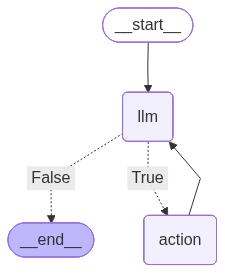

In [39]:
from IPython.display import Image, display

display(Image(agent.graph.get_graph().draw_mermaid_png()))


In [40]:
messages = [
    HumanMessage(content="How is the current weather in Google Headquarters?")
]

result = agent.graph.invoke({'messages': messages})
print(f"Answer: {result['messages'][-1].content}")

Calling: {'name': 'get_weather', 'args': {'location': 'Google Headquarters'}, 'id': '69q77zknv', 'type': 'tool_call'}
Back to the model!
Calling: {'name': 'ddg_search', 'args': {'query': 'Google Headquarters address'}, 'id': 'p1vm4gwnx', 'type': 'tool_call'}
Back to the model!
Calling: {'name': 'get_weather', 'args': {'location': 'Mountain View'}, 'id': '39qmm06w6', 'type': 'tool_call'}
Back to the model!
Answer: The current temperature in Mountain View, where Google Headquarters is located, is 17.1°C.
